In [28]:
from vedo import dataurl, Mesh, Plotter, Volume, settings
import numpy as np
import pandas as pd

settings.default_backend = 'k3d'
filepath = "..\shapes\AquaticAnimal\m53.obj"
mesh = Mesh(filepath).c("violet").flat()

# Set the backcolor of the mesh to violet
# and show edges with a linewidth of 2
mesh.backcolor('violet').linecolor('tomato').linewidth(2)
plot = Plotter(bg='black')
plot.show(mesh)

Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], camera_…

In [29]:
"""
Input: Mesh
Output: Normalized Mesh
"""
def normalize_position(mesh:Mesh):
    infotxt= f"""
    {len(mesh.vertices)},
    {mesh.scale()},
    {mesh.average_size()},
    {mesh.diagonal_size()},
    {mesh.center_of_mass()},
    {mesh.bounds()},
    {mesh.pos()}
    {np.mean(mesh.vertices,axis=0)}  
    """
    print(infotxt)

normalize_position(mesh)


    18409,
    [1. 1. 1.],
    0.21570685505867004,
    1.0131474709780592,
    [0.10102272 0.16914467 0.66439275],
    [0.025    0.163371 0.025    0.348761 0.025    0.975   ],
    [0. 0. 0.]
    [0.10102272 0.1691444  0.6643906 ]  
    


In [37]:
import os
rootdir = '../shapes'
paths = []
vertices = []
com = []
means = []
scalings = []
s_average = []
s_diagonal = []
bounds = []
positions = []

limit = 100
i = 0 
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if(file.endswith(".obj")):
            if(limit!=None and i>limit):
                break
                
            path = os.path.join(subdir, file)
            print(f"Reading {path}")
            paths.append(path)
            mesh = Mesh(path)
            vertices.append(len(mesh.vertices))
            com.append(mesh.center_of_mass())
            means.append(np.mean(mesh.vertices,axis=0))
            scalings.append( mesh.scale())
            s_average.append(mesh.average_size())
            s_diagonal.append(mesh.diagonal_size())
            positions.append(mesh.pos())
            bounds.append(mesh.bounds())
            i+=1

df = pd.DataFrame({"Path":paths,"Vertices":vertices,"CenterOfMass":com,"Means":means,"Scaling":scalings,"AverageSize":s_average,"DiagonalSize":s_diagonal,"Bounds":bounds,"Position":positions})

print(df)   

Reading ../shapes\AircraftBuoyant\m1337.obj
Reading ../shapes\AircraftBuoyant\m1338.obj
Reading ../shapes\AircraftBuoyant\m1339.obj
Reading ../shapes\AircraftBuoyant\m1340.obj
Reading ../shapes\AircraftBuoyant\m1341.obj
Reading ../shapes\AircraftBuoyant\m1342.obj
Reading ../shapes\AircraftBuoyant\m1343.obj
Reading ../shapes\AircraftBuoyant\m1344.obj
Reading ../shapes\AircraftBuoyant\m1345.obj
Reading ../shapes\AircraftBuoyant\m1346.obj
Reading ../shapes\AircraftBuoyant\m1347.obj
Reading ../shapes\AircraftBuoyant\m1348.obj
Reading ../shapes\AircraftBuoyant\m1349.obj
Reading ../shapes\AircraftBuoyant\m1350.obj
Reading ../shapes\AircraftBuoyant\m1351.obj
Reading ../shapes\AircraftBuoyant\m1352.obj
Reading ../shapes\Apartment\D00045.obj
Reading ../shapes\Apartment\D00086.obj
Reading ../shapes\Apartment\D00138.obj
Reading ../shapes\Apartment\D00156.obj
Reading ../shapes\Apartment\D00310.obj
Reading ../shapes\Apartment\D00348.obj
Reading ../shapes\Apartment\D00366.obj
Reading ../shapes\Apart

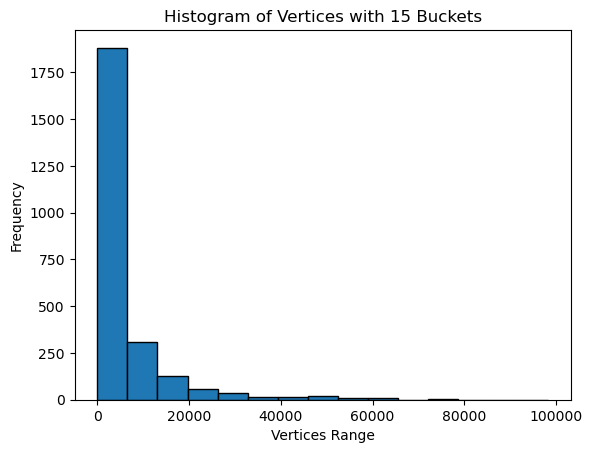

In [38]:
import matplotlib.pyplot as plt
plt.hist(df['Vertices'], bins=15, edgecolor='black')

# Adding labels and title
plt.xlabel('Vertices Range')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices with 15 Buckets')

# Display the histogram
plt.show()

In [43]:
def euclidean_distances(list1, list2):
    distances = []
    for point1, point2 in zip(list1, list2):
        # Convert points to NumPy arrays for easier calculations
        p1 = np.array(point1)
        p2 = np.array(point2)
        # Calculate Euclidean distance
        distance = np.linalg.norm(p1 - p2)
        distances.append(distance)
    return distances

In [47]:
distances = euclidean_distances(df["CenterOfMass"], df["Means"])

print(min(distances))

3.702270432229202e-09


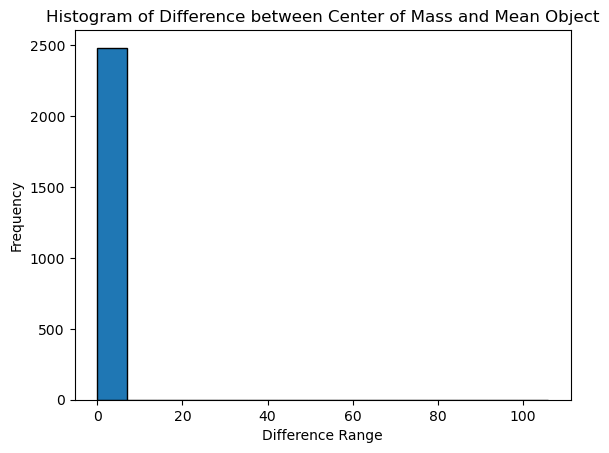

In [45]:
plt.hist(distances, bins=15, edgecolor='black')

# Adding labels and title
plt.xlabel('Difference Range')
plt.ylabel('Frequency')
plt.title('Histogram of Difference between Center of Mass and Mean Object')

# Display the histogram
plt.show()

In [48]:
len(df)

2483